In [88]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [89]:
from pathlib import Path

def update_column_names_in_csv(folder_path):
    """
    Iteratively checks CSV files in the specified folder.
    If 'subregion2_name' is missing but 'locality_name' is present, 
    it renames 'locality_name' to 'subregion2_name' and saves the file.
    """
    folder = Path(folder_path)
    csv_files = folder.glob('*.csv')
    
    for csv_file in csv_files:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file)
        
        # Check and rename column if necessary
        if 'subregion2_name' not in df.columns and 'locality_name' in df.columns:
            print(f"Updating '{csv_file.name}': 'locality_name' -> 'subregion2_name'")
            df.rename(columns={'locality_name': 'subregion2_name'}, inplace=True)
            
            # Save the updated DataFrame back to CSV
            df.to_csv(csv_file, index=False)



In [87]:
folder_path = '../All CSVs'
update_column_names_in_csv(folder_path)

Updating 'US_NY_NYC.csv': 'locality_name' -> 'subregion2_name'


In [90]:

state_fips_to_full_info = {
    '01': ['AL', 'Alabama'],
    '02': ['AK', 'Alaska'],
    '04': ['AZ', 'Arizona'],
    '05': ['AR', 'Arkansas'],
    '06': ['CA', 'California'],
    '08': ['CO', 'Colorado'],
    '09': ['CT', 'Connecticut'],
    '10': ['DE', 'Delaware'],
    '11': ['DC', 'District of Columbia'],
    '12': ['FL', 'Florida'],
    '13': ['GA', 'Georgia'],
    '15': ['HI', 'Hawaii'],
    '16': ['ID', 'Idaho'],
    '17': ['IL', 'Illinois'],
    '18': ['IN', 'Indiana'],
    '19': ['IA', 'Iowa'],
    '20': ['KS', 'Kansas'],
    '21': ['KY', 'Kentucky'],
    '22': ['LA', 'Louisiana'],
    '23': ['ME', 'Maine'],
    '24': ['MD', 'Maryland'],
    '25': ['MA', 'Massachusetts'],
    '26': ['MI', 'Michigan'],
    '27': ['MN', 'Minnesota'],
    '28': ['MS', 'Mississippi'],
    '29': ['MO', 'Missouri'],
    '30': ['MT', 'Montana'],
    '31': ['NE', 'Nebraska'],
    '32': ['NV', 'Nevada'],
    '33': ['NH', 'New Hampshire'],
    '34': ['NJ', 'New Jersey'],
    '35': ['NM', 'New Mexico'],
    '36': ['NY', 'New York'],
    '37': ['NC', 'North Carolina'],
    '38': ['ND', 'North Dakota'],
    '39': ['OH', 'Ohio'],
    '40': ['OK', 'Oklahoma'],
    '41': ['OR', 'Oregon'],
    '42': ['PA', 'Pennsylvania'],
    '44': ['RI', 'Rhode Island'],
    '45': ['SC', 'South Carolina'],
    '46': ['SD', 'South Dakota'],
    '47': ['TN', 'Tennessee'],
    '48': ['TX', 'Texas'],
    '49': ['UT', 'Utah'],
    '50': ['VT', 'Vermont'],
    '51': ['VA', 'Virginia'],
    '53': ['WA', 'Washington'],
    '54': ['WV', 'West Virginia'],
    '55': ['WI', 'Wisconsin'],
    '56': ['WY', 'Wyoming']
}








In [91]:

def assign_color(rate):
    """Assigns a color based on the normalized incidence rate, handling NaN values."""
    # Check if rate is NaN
    if pd.isna(rate):
        # Return a default color, e.g., gray
        return '#808080'  # Gray color in hex
    else:
        red = int(rate * 255)
        green = 255 - red
        blue = 0  # Blue component remains 0 throughout
        # Convert RGB to hex
        return '#{:02x}{:02x}{:02x}'.format(red, green, blue)


In [92]:

from pathlib import Path

def process_files_in_folder_pathlib(folder_path):
    files_list = []  # Creates a list of all files in a given folder as strings
    folder = Path(folder_path)
    for file in folder.glob('*.csv'):  # Changed pattern to '*.csv' to filter files
        if file.is_file():
            files_list.append(str(file))  # Convert Path object to string
        else:
            print(f"{file} is a directory, skipping.\n")
    return files_list  # Return the list of file paths as strings




In [93]:
# Define the folder path containing your CSV files
folder_path = "../All CSVs"
csv_files = process_files_in_folder_pathlib(folder_path)


In [94]:

# Assuming state_fips_to_full_info is defined as before
# Invert the dictionary to map state names to FIPS codes
name_to_fips = {info[1]: fips for fips, info in state_fips_to_full_info.items()}



In [100]:
import pandas as pd
from pathlib import Path


def process_files_and_aggregate_data(csv_files):
    monthly_stats = pd.DataFrame()

    for file_path in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check for required columns and print a message if any are missing
        required_columns = ['date', 'cumulative_deceased', 'new_deceased', 'subregion2_name', 'population', 'subregion1_name']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"File '{file_path}' is missing columns: {missing_columns}")
            continue  # Skip to the next file

        # Convert 'date' column to datetime format
        df['date'] = pd.to_datetime(df['date'])

        # Prepare the aggregation dictionary
        agg_dict = {
            'population': 'last',
            'new_deceased': 'sum',
            'cumulative_deceased': 'last'
        }

        # Optionally include vaccination columns if present
        if 'new_persons_fully_vaccinated' in df.columns and 'cumulative_persons_fully_vaccinated' in df.columns:
            agg_dict.update({
                'new_persons_fully_vaccinated': 'sum',
                'cumulative_persons_fully_vaccinated': 'last'
            })

        # Group by 'subregion1_name', 'subregion2_name' (if present), and month, then aggregate
        group_cols = ['subregion1_name', 'subregion2_name'] if 'subregion2_name' in df.columns else ['subregion1_name']
        group_cols.append(pd.Grouper(key='date', freq='ME'))  # Group by month using the 'date' column
        monthly_data = df.groupby(group_cols).agg(agg_dict).reset_index()

        # Map state names to FIPS codes, if 'subregion1_name' is present
        if 'subregion1_name' in df.columns:
            monthly_data['state_fips'] = monthly_data['subregion1_name'].map(name_to_fips)

        # Calculate additional statistics if necessary columns are present
        if 'new_deceased' in df.columns and 'population' in df.columns:
            monthly_data['incidence_rate'] = (monthly_data['new_deceased'] / monthly_data['population']) * 100000

        # Normalize the incidence rate to a range between 0 and 1, if 'incidence_rate' is calculated
        if 'incidence_rate' in monthly_data.columns:
            monthly_data['normalized_incidence_rate'] = (monthly_data['incidence_rate'] - monthly_data['incidence_rate'].min()) / (monthly_data['incidence_rate'].max() - monthly_data['incidence_rate'].min())
            monthly_data['color'] = monthly_data['normalized_incidence_rate'].apply(assign_color)

        # Append the processed data to the aggregated DataFrame
        monthly_stats = pd.concat([monthly_stats, monthly_data], ignore_index=True)

    return monthly_stats

# Example usage

csv_files = [str(f) for f in Path(folder_path).glob('*.csv')]
monthly_stats = process_files_and_aggregate_data(csv_files)

if not monthly_stats.empty:
    print(monthly_stats.head())
    # Save the aggregated data to a CSV file
    output_path = 'Modified Data/aggregated_monthly_stats.csv'
    monthly_stats.to_csv(output_path, index=False)
else:
    print("No data was aggregated.")


File '..\All CSVs\US_AK_02060.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_AK_02105.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_AK_02164.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_AK_02282.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_CA_SFO.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72001.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72003.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72005.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72007.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72009.csv' is missing columns: ['cumulative_deceased', 'new_deceased']
File '..\All CSVs\US_PR_72011.csv' is missing column

In [118]:
shp_file_path = 'tl_2023_us_county.shp'
csv_file_path = 'Modified Data/aggregated_monthly_stats.csv'
date = '2021-08-31'  # Use the correct date format as in your CSV
title = 'COVID-19 Incidence Rates by County for August 31, 2021'
colorized_shp_file_path = 'colorized_tl_2023_us_county.shp'
columns_to_keep = ['subregion1_name', 'subregion2_name', 'state_fips', 'color']

output_png_path = 'Test_img.png'

In [105]:
def filter_csv_by_date_and_columns(csv_file_path, date, columns_to_keep):
    """
    Filter a CSV file to only include rows for a specific date and a subset of columns.

    Parameters:
    - csv_file_path: Path to the CSV file.
    - date: The specific date to filter for (as a string).
    - columns_to_keep: List of columns to keep in the filtered DataFrame.

    Returns:
    - A filtered DataFrame with correctly formatted state_fips codes.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Convert the 'date' column to datetime to ensure proper comparison
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter the DataFrame for the given date
    filtered_df = df[df['date'] == pd.Timestamp(date)]
    
    # Reduce the DataFrame to only include the specified columns
    filtered_df = filtered_df[columns_to_keep]
    
    # Ensure 'state_fips' is a string and add leading zeros if necessary
    if 'state_fips' in filtered_df.columns:
        filtered_df['state_fips'] = filtered_df['state_fips'].apply(lambda x: str(x).zfill(2))
    
    return filtered_df


In [124]:
filtered_df = filter_csv_by_date_and_columns(csv_file_path, date, columns_to_keep)

# First, ensure 'state_fips' is numeric and handle any non-numeric gracefully by converting them to NaN
filtered_df['state_fips'] = pd.to_numeric(filtered_df['state_fips'], errors='coerce')

# Drop rows with NaN values in 'state_fips' if any remain
filtered_df = filtered_df.dropna(subset=['state_fips'])

# Now, safely convert to int (since we've ensured all are float/numeric and no NaN values exist)
filtered_df['state_fips'] = filtered_df['state_fips'].astype(int)

if 'state_fips' in filtered_df.columns:
        filtered_df['state_fips'] = filtered_df['state_fips'].apply(lambda x: str(x).zfill(2))

# Verify changes
filtered_df.head()


,subregion1_name,subregion2_name,state_fips,color
19,Alaska,Aleutians East,02,#00ff00
52,Alaska,Aleutians West,02,#00ff00
85,Alaska,Anchorage Municipality,02,#798600
118,Alaska,Bethel,02,#00ff00
151,Alaska,Denali,02,#00ff00


In [125]:
filtered_df

,subregion1_name,subregion2_name,state_fips,color
19,Alaska,Aleutians East,02,#00ff00
52,Alaska,Aleutians West,02,#00ff00
85,Alaska,Anchorage Municipality,02,#798600
118,Alaska,Bethel,02,#00ff00
151,Alaska,Denali,02,#00ff00
...,...,...,...,...
103573,Wyoming,Sweetwater County,56,#3cc300
103606,Wyoming,Teton County,56,#00ff00
103639,Wyoming,Uinta County,56,#19e600
103672,Wyoming,Washakie County,56,#17e800


In [134]:
def merge_shapefile_with_data(shp_file_path, filtered_df, output_file_path):
    # Load the shapefile data
    us_counties = gpd.read_file(shp_file_path)
    print("Length of shape file is", len(us_counties))
    # Ensure the columns used for merging are in the correct data type
    filtered_df['state_fips'] = filtered_df['state_fips'].astype(str)

    # Before merging, ensure that 'color' column exists in filtered_df with default grey for missing values
    if 'color' not in filtered_df.columns or filtered_df['color'].isnull().all():
        filtered_df['color'] = '#808080'  # Default grey color in hex

    else:
        # Fill missing color values with grey
        filtered_df['color'].fillna('#808080', inplace=True)
    
    # Merge the filtered DataFrame with the GeoDataFrame
    merged_gdf = us_counties.merge(filtered_df, left_on=['STATEFP', 'NAMELSAD'], right_on=['state_fips', 'subregion2_name'], how='left')
    
    # After merging, ensure that any rows in merged_gdf without a 'color' value are set to grey
    # This handles counties in the shapefile that were not present in filtered_df
    if 'color' not in merged_gdf.columns or merged_gdf['color'].isnull().all():
        merged_gdf['color'] = '#808080'  # Default grey color in hex
    else:
        merged_gdf['color'].fillna('#808080', inplace=True)
    print("Number of grey changes:", )
    # Save the merged GeoDataFrame for future use
    merged_gdf.to_file(output_file_path)

    return merged_gdf


In [127]:
merged_df = merge_shapefile_with_data(shp_file_path, filtered_df, colorized_shp_file_path)

Length of shape file is 3235
Number of grey changes:


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\883865769.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\883865769.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [128]:
merged_df['color'].value_counts()

color
#00ff00    743
#808080    181
#24db00     78
#55aa00     76
#2ad500     68
          ... 
#9b6400      1
#f40b00      1
#c63900      1
#c93600      1
#e61900      1
Name: count, Length: 199, dtype: int64

In [129]:
def plot_counties_from_merged_gdf(merged_gdf_path, title, output_png_path):
    # Load the merged shapefile into a GeoDataFrame
    merged_gdf = gpd.read_file(merged_gdf_path)

    # Define the continental US bounds
    continental_us_bounds = {
        "minx": -130,
        "miny": 24,
        "maxx": -66,
        "maxy": 50
    }
    
    # Create a figure and axis with specified figsize and resolution (DPI)
    fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
    
    # Set the bounds for the continental US
    ax.set_xlim(continental_us_bounds["minx"], continental_us_bounds["maxx"])
    ax.set_ylim(continental_us_bounds["miny"], continental_us_bounds["maxy"])
    
    # Plot all counties in the dataset with a neutral color to provide a base map
    merged_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.4)
    
    # Overlay the counties with specified colors where available
    merged_gdf['color'] = merged_gdf['color'].apply(lambda x: '#{:02x}{:02x}{:02x}'.format(*x) if isinstance(x, tuple) else x)
    merged_gdf.dropna(subset=['color']).plot(ax=ax, color=merged_gdf['color'], edgecolor='black', linewidth=0.4)
    
    # Adjust plot parameters
    ax.set_title(title)
    ax.set_axis_off()
    
    # Save the figure to a PNG file with the specified path and high resolution
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()


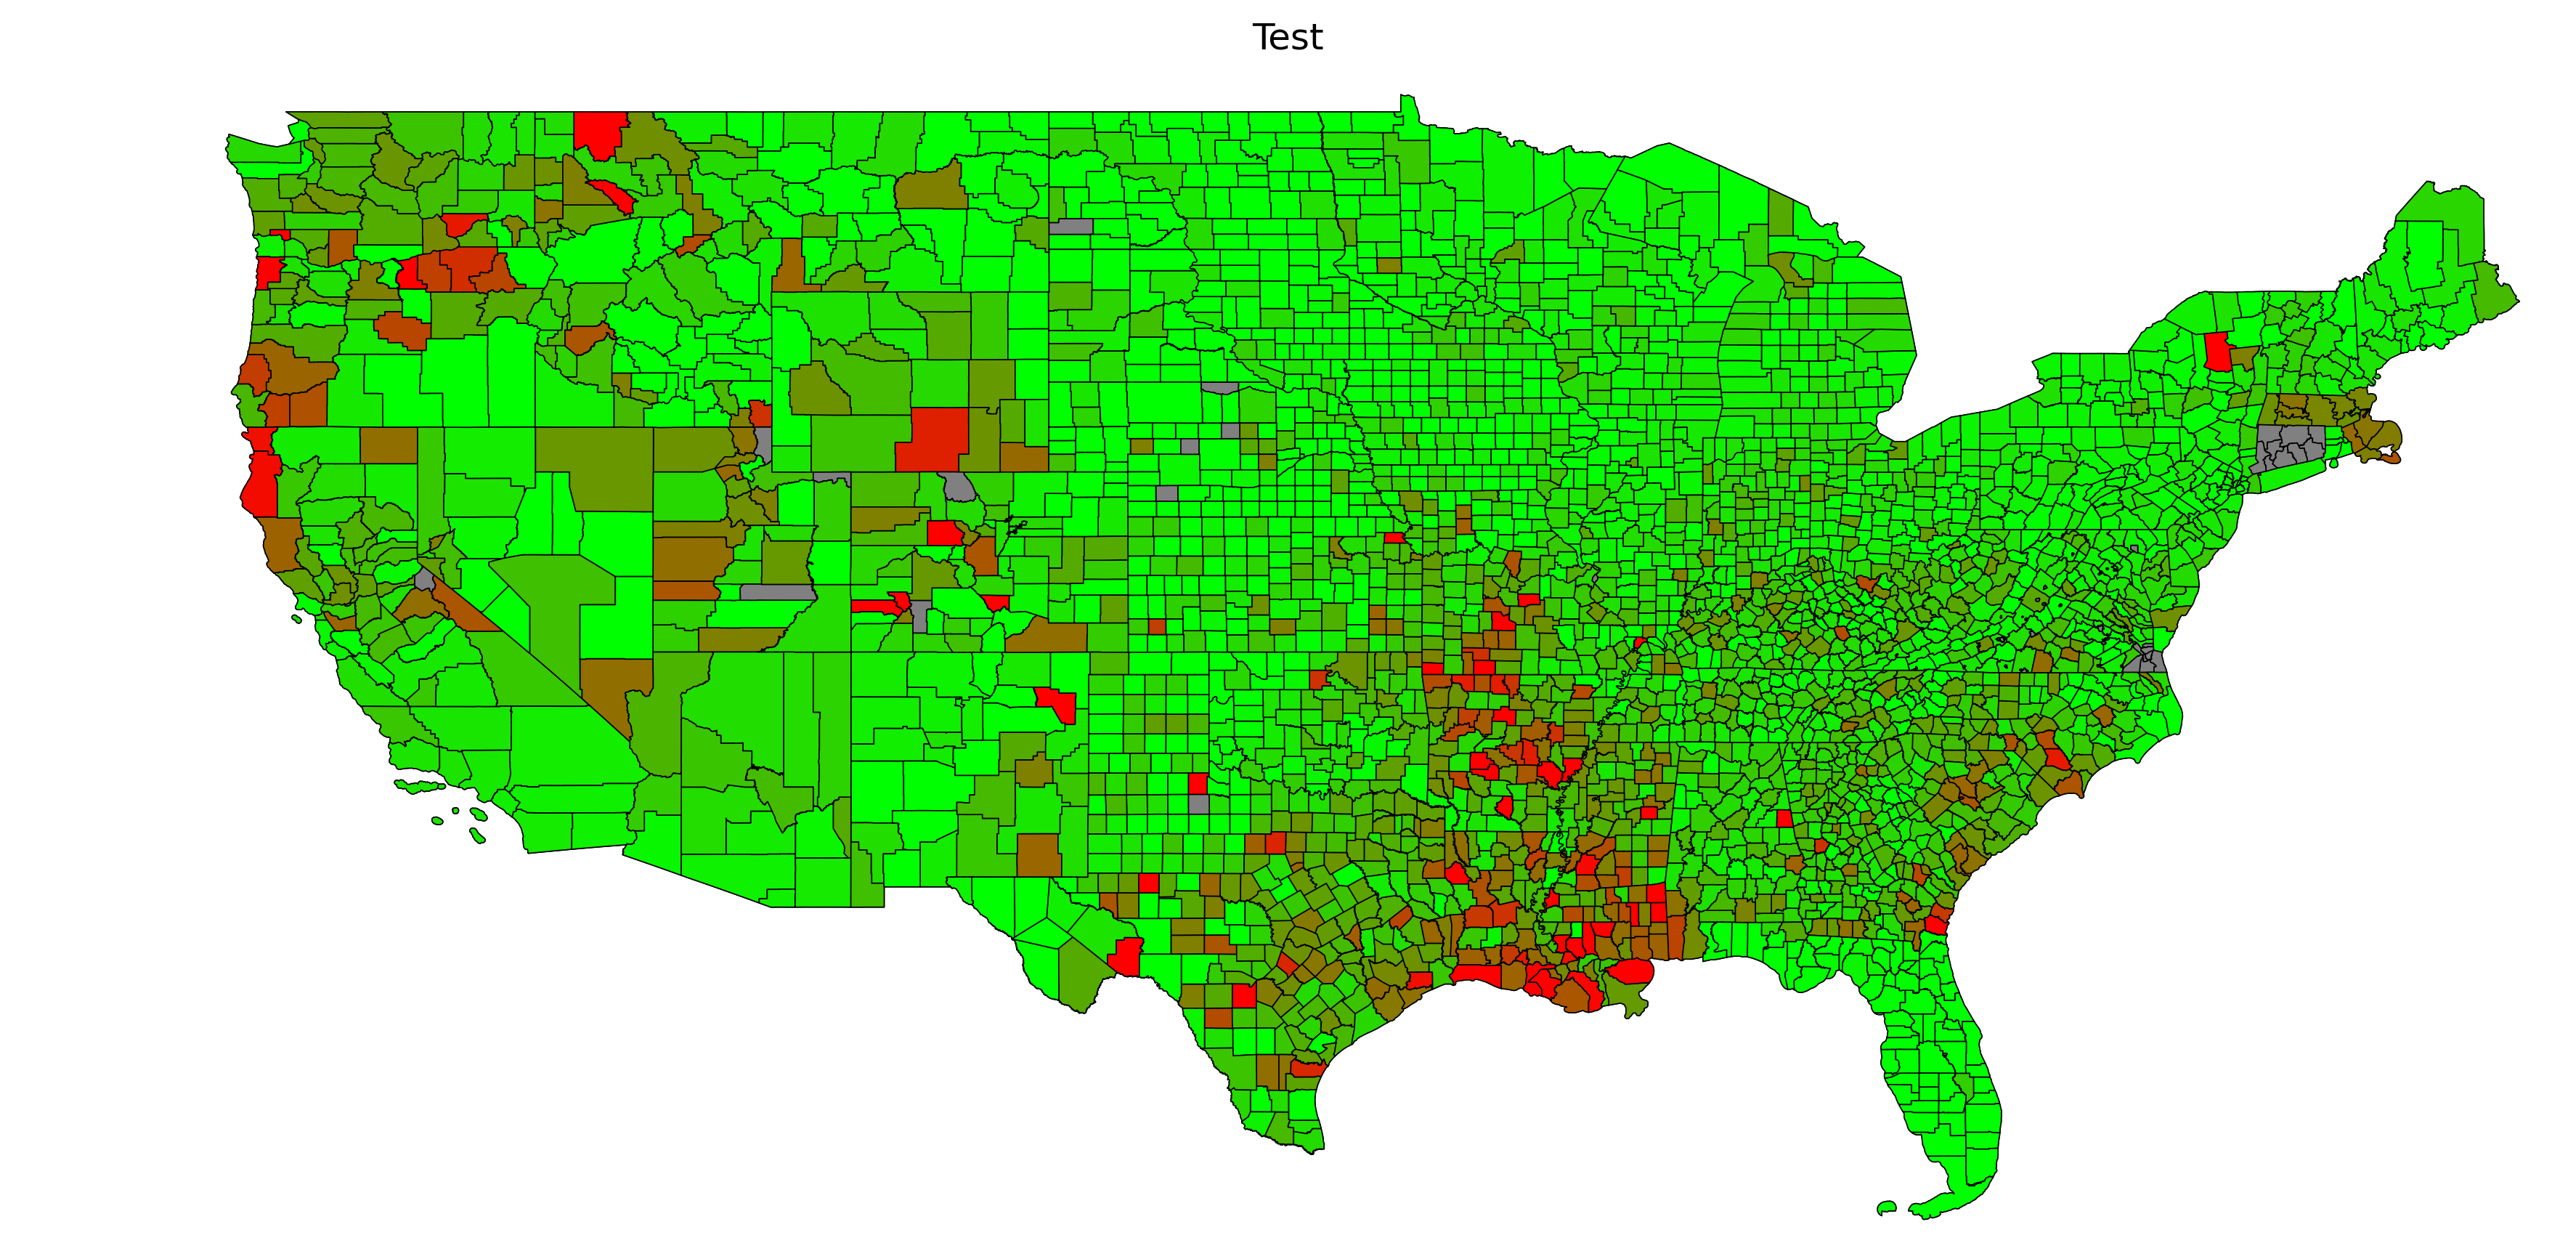

In [130]:
plot_counties_from_merged_gdf(colorized_shp_file_path, "Month Ending in {date}", "{}")

# Attempt at iterating through each month in aggregated_monthly_stats.csv

In [174]:
import pandas as pd

# Load the aggregated monthly statistics CSV
csv_file_path = 'Modified Data/aggregated_monthly_stats.csv'
df = pd.read_csv(csv_file_path)

# Extract unique raw dates directly from the 'date' column and sort them
unique_dates = sorted(df['date'].unique())

print(unique_dates)


['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30']


In [180]:
def filter_csv_by_date_and_columns(csv_file_path, date, columns_to_keep):
    """
    Filter a CSV file to only include rows for a specific date and a subset of columns.

    Parameters:
    - csv_file_path: Path to the CSV file.
    - date: The specific date to filter for (as a string).
    - columns_to_keep: List of columns to keep in the filtered DataFrame.

    Returns:
    - A filtered DataFrame with correctly formatted state_fips codes.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Convert the 'date' column to datetime to ensure proper comparison
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter the DataFrame for the given date
    filtered_df = df[df['date'] == pd.Timestamp(date)]
    
    # Reduce the DataFrame to only include the specified columns
    filtered_df = filtered_df[columns_to_keep]
    filtered_df['state_fips'] = pd.to_numeric(filtered_df['state_fips'], errors='coerce')

    # Drop rows with NaN values in 'state_fips' if any remain
    filtered_df = filtered_df.dropna(subset=['state_fips'])

    # Now, safely convert to int (since we've ensured all are float/numeric and no NaN values exist)
    filtered_df['state_fips'] = filtered_df['state_fips'].astype(int)

    if 'state_fips' in filtered_df.columns:
            filtered_df['state_fips'] = filtered_df['state_fips'].apply(lambda x: str(x).zfill(2))

    # Verify changes
    print(filtered_df.head(1))


    return filtered_df


In [192]:
def merge_shapefile_with_data(us_counties, filtered_df, output_file_path):
    # Ensure the columns used for merging are in the correct data type
    filtered_df['state_fips'] = filtered_df['state_fips'].astype(str)

    # Before merging, ensure that 'color' column exists in filtered_df with default grey for missing values
    if 'color' not in filtered_df.columns or filtered_df['color'].isnull().all():
        filtered_df['color'] = '#808080'  # Default grey color in hex
    else:
        # Fill missing color values with grey
        filtered_df['color'].fillna('#808080', inplace=True)
    
    # Merge the filtered DataFrame with the GeoDataFrame
    merged_gdf = us_counties.merge(filtered_df, left_on=['STATEFP', 'NAMELSAD'], right_on=['state_fips', 'subregion2_name'], how='left')
    
    # After merging, ensure that any rows in merged_gdf without a 'color' value are set to grey
    if 'color' not in merged_gdf.columns or merged_gdf['color'].isnull().all():
        merged_gdf['color'] = '#808080'  # Default grey color in hex
    else:
        merged_gdf['color'].fillna('#808080', inplace=True)
    
    # Convert 'date' column to string to ensure compatibility with all file formats
    if 'date' in merged_gdf.columns:
        merged_gdf['date'] = merged_gdf['date'].astype(str)

    # Save the merged GeoDataFrame for future use
    merged_gdf.to_file(output_file_path)

    return merged_gdf


In [186]:
shp_file_path = 'tl_2023_us_county.shp'
shape_df = gpd.read_file(shp_file_path)


In [194]:
for date in unique_dates[0:2]:
    filtered_df = filter_csv_by_date_and_columns(csv_file_path, date, columns_to_keep)
    merged_gdf = merge_shapefile_with_data(shape_df, filtered_df, "Modified Data/Shapefiles/{} geo.shp".format(date) )
    

  subregion1_name subregion2_name state_fips    color       date
0          Alaska  Aleutians East         02  #00ff00 2020-01-31


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\388494503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\388494503.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

  subregion1_name subregion2_name state_fips    color       date
1          Alaska  Aleutians East         02  #00ff00 2020-02-29


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\388494503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_18636\388494503.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

KeyboardInterrupt: 